This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [102]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
# indices - used later
indices = np.arange(len(features))
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [103]:
from humancompatible.train.optim import SSLALM
import torch
from torch.nn import Sequential

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

hsize1 = 32
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

m = len(list(model.parameters()))

optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.]*m

epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()

In [104]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )
            norm_viol.backward()
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference
            optimizer.dual_step(i, c_val=norm_viol.squeeze())
            optimizer.zero_grad()
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        optimizer.step()
        optimizer.zero_grad()
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5532674789428711, constraints: [0.89685833 0.31275    1.0004585  0.587758   0.8913593  0.18107855], dual: [0.17289184 0.         0.26543552 0.         0.21369153 0.        ]
Epoch: 1, loss: 0.4471386969089508, constraints: [0.99978864 0.8684292  0.99948835 0.76891136 0.9997171  0.2271289 ], dual: [0.22940893 0.03098314 0.3188885  0.         0.28043842 0.        ]
Epoch: 2, loss: 0.4334107041358948, constraints: [0.99947023 0.99992883 0.9992218  0.8209013  0.99935824 0.24544159], dual: [0.26794466 0.04828436 0.3663949  0.         0.33131924 0.        ]
Epoch: 3, loss: 0.42678001523017883, constraints: [0.9992512  0.9997956  0.998925   0.8497179  0.9990705  0.25241992], dual: [0.29948142 0.05794698 0.40728757 0.         0.37486073 0.        ]
Epoch: 4, loss: 0.4218577444553375, constraints: [0.99913895 0.9997516  0.9987288  0.8694501  0.9988471  0.24598958], dual: [0.32611576 0.06572881 0.4426239  0.         0.41369608 0.        ]
Epoch: 5, loss: 0.4180023968219757, con

The model is now trained subject to the constraints we set.

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [105]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

And start training:

In [106]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 50

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in dataloader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.4335234022733192
Epoch: 1, loss: 0.395945837353219
Epoch: 2, loss: 0.3824553429770511
Epoch: 3, loss: 0.369049969602189
Epoch: 4, loss: 0.3546986985318944
Epoch: 5, loss: 0.3379009627758088
Epoch: 6, loss: 0.32164580593340786
Epoch: 7, loss: 0.30228790178236453
Epoch: 8, loss: 0.28615535839752937
Epoch: 9, loss: 0.2708318519181664
Epoch: 10, loss: 0.2570561399655917
Epoch: 11, loss: 0.2437935567289862
Epoch: 12, loss: 0.23094994132528066
Epoch: 13, loss: 0.21964456023873544
Epoch: 14, loss: 0.21045354748729042
Epoch: 15, loss: 0.19995889921194068
Epoch: 16, loss: 0.192854344116264
Epoch: 17, loss: 0.18411669322508234
Epoch: 18, loss: 0.17738556498336805
Epoch: 19, loss: 0.170041063193022
Epoch: 20, loss: 0.16370268535366092
Epoch: 21, loss: 0.15809278319423545
Epoch: 22, loss: 0.15449921297157312
Epoch: 23, loss: 0.14672562409894144
Epoch: 24, loss: 0.1408188405314026
Epoch: 25, loss: 0.1427337113929825
Epoch: 26, loss: 0.1350462194553845
Epoch: 27, loss: 0.1308172304

In [107]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3571, 0.5104], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [121]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [122]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

from humancompatible.train.optim import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 50

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$, where $S$ is the set of groups.

In [124]:
import pandas as pd
import random

ep_c_log = []


for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []

    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4696178436279297, constraints: [0.15397712], dual: [0.03254585]
Epoch: 1, loss: 0.39999011158943176, constraints: [0.19120529], dual: [0.02116163]
Epoch: 2, loss: 0.3864804208278656, constraints: [0.20197815], dual: [0.06065913]
Epoch: 3, loss: 0.37928053736686707, constraints: [0.19435477], dual: [0.0041026]


KeyboardInterrupt: 

In [111]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3982, 0.4734], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [112]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.1722, dtype=torch.float64, grad_fn=<SumBackward0>)

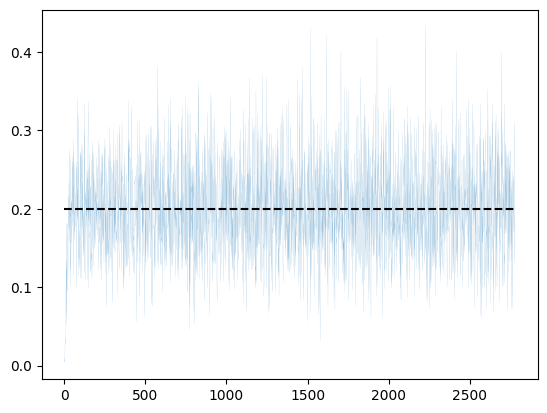

In [113]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [114]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [115]:
from humancompatible.train.optim import SSG

from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.05,
    dual_lr=0.05
)

epochs = 150

In [116]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
    ep_c_log.append(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.6120140552520752, constraints: [0.03801346], 
Epoch: 1, loss: 0.44746190309524536, constraints: [0.11390783], 
Epoch: 2, loss: 0.4247603714466095, constraints: [0.1164844], 
Epoch: 3, loss: 0.4123891294002533, constraints: [0.11082221], 
Epoch: 4, loss: 0.4082682430744171, constraints: [0.11696927], 
Epoch: 5, loss: 0.400370329618454, constraints: [0.12095719], 
Epoch: 6, loss: 0.39809325337409973, constraints: [0.11640403], 
Epoch: 7, loss: 0.3986223042011261, constraints: [0.11810578], 
Epoch: 8, loss: 0.3914393484592438, constraints: [0.11258486], 
Epoch: 9, loss: 0.3909356892108917, constraints: [0.11470237], 
Epoch: 10, loss: 0.38716766238212585, constraints: [0.11842831], 
Epoch: 11, loss: 0.38616442680358887, constraints: [0.11533407], 
Epoch: 12, loss: 0.38243332505226135, constraints: [0.11226482], 
Epoch: 13, loss: 0.3805866837501526, constraints: [0.13182428], 
Epoch: 14, loss: 0.3775826394557953, constraints: [0.11603429], 
Epoch: 15, loss: 0.3776049613952

In [117]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4304, 0.4746], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [118]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0976, dtype=torch.float64, grad_fn=<SumBackward0>)

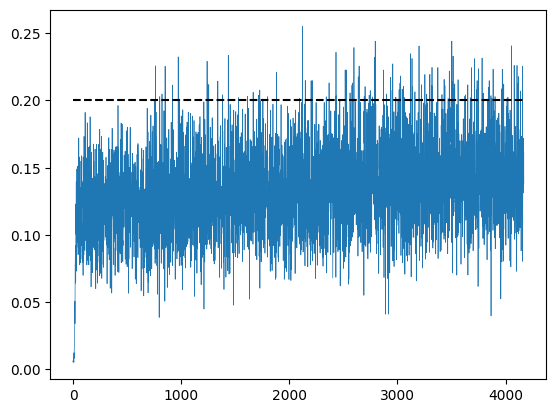

In [119]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')